- Training and testing with IMU-Acceleration measurements (Movesense dataset)


In [1]:
# Importing libraries 
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from keras import layers
import tensorflow as tf
import keras 
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.signal import butter, filtfilt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load the labelled movensense dataset
folder_path_imu ='C:/Users/val-c/Desktop/movesense_lblled_imu' 
# Get the list of all files in the folder_location
file_list = os.listdir(folder_path_imu)
# Loop via the list of files & read them into pd
dataframes = []
for file_name in file_list:
    if file_name.endswith(".csv"):  # files in csv format
        file_path = os.path.join(folder_path_imu, file_name)
        df = pd.read_csv(file_path)
        dataframes.append(df)
# Combine all the data_frame into one
movement_data = pd.concat(dataframes, ignore_index=True)
movement_data.head(n=5) # display first-five rows

,x,y,z,gx,gy,gz,classes
0,1.081595,9.786994,0.844697,-7.77,-18.550000,-6.30,1
1,1.131846,9.736743,0.940413,-7.91,-20.160000,-7.84,1
2,1.103131,9.645813,0.949985,-8.26,-22.120000,-9.10,1
3,1.060058,9.595561,0.897341,-8.82,-24.430000,-10.15,1
4,1.076809,9.454380,0.909305,-9.66,-26.880001,-10.71,1


In [3]:
# Drop the gyroscope measurements from the dataframe
movement_data=movement_data.drop(['gx','gy','gz'],axis=1)

In [4]:
# Display info of the dataframe
movement_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34180 entries, 0 to 34179
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   x        34180 non-null  float64
 1   y        34180 non-null  float64
 2   z        34180 non-null  float64
 3   classes  34180 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 1.0 MB


In [5]:
# Check for missing values
movement_data.isna().sum(axis=0).to_frame('Total')

,Total
x,0
y,0
z,0
classes,0


In [6]:
# Class labels in the dataframe (df)
unique_label = np.unique(movement_data.classes)
class_label = np.sort(unique_label)
print(class_label)

[ 1  2  3  4  5  6  7  8  9 10 11 12]


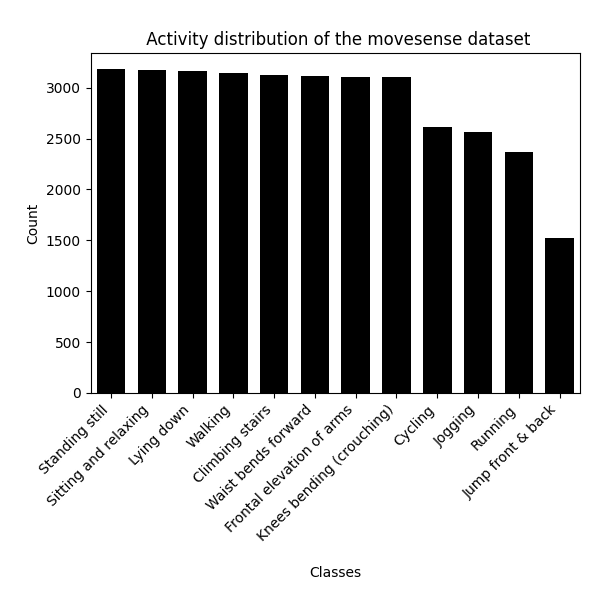

In [7]:
# Plot the number of samples present in each class_label
class_label = ['Standing still','Sitting and relaxing','Lying down','Walking', 'Climbing stairs',
               'Waist bends forward', 'Frontal elevation of arms','Knees bending (crouching)',
               'Cycling','Jogging','Running','Jump front & back']
plt.figure(figsize=(6, 6)) # figure sizing 
num_of_classes = len(class_label)
# Creating barplot for the activitiy distribution in the df
sns.barplot(x=class_label, y=movement_data["classes"].value_counts(), color='k', width=0.7)
# Replace the numerical x-axis ticks with class labels
plt.xticks(range(num_of_classes), class_label, rotation=45, ha='right')
# the x-axis and y-axis labels, title
plt.xlabel('\nClasses', fontsize=10)
plt.ylabel('\nCount', fontsize=10)
plt.title("\n Activity distribution of the movesense dataset", fontsize=12)
#display plot
plt.tight_layout()
plt.show()

In [8]:
# Statistics of the test data dataframe
movement_data.describe().T

,count,mean,std,min,25%,50%,75%,max
x,34180.0,-0.698931,2.919262,-13.342855,-0.619763,0.021536,0.502511,14.780993
y,34180.0,8.342204,4.382568,-16.341170,7.135652,9.258162,9.705635,58.250560
z,34180.0,0.290473,3.241940,-17.343798,-0.492939,0.871019,1.931077,17.082972
classes,34180.0,6.193915,3.398560,1.000000,3.000000,6.000000,9.000000,12.000000


In [9]:
# Data filtering
# Columns of the dataframe to apply filtering
cols=['x', 'y', 'z']
# filtering the sensor signal from noise
# low pass filtering > remove high frequency noise
## Defining the low-pass filter parameters
cutoff_freq = 20 # hz
fs = 52  # sampling rate (Hz)
nyquist_freq = 0.5 * fs
n_order = 3 #filter_order
# Designing the Butterworth filter
b, a = butter(n_order , cutoff_freq/nyquist_freq, btype='low')
# Applying the filter to the selected data_columns
filtered_data = filtfilt(b, a,movement_data[cols].values, axis=0)
#assign the filtered data to the dataframe
filtered_movement_data= pd.DataFrame(filtered_data, columns=cols) # put the filtered data to df
filtered_movement_data['classes'] = movement_data['classes'] # assign back the labels
# Display the filtered DataFrame
filtered_movement_data.head() # display first_five rows

,x,y,z,classes
0,1.081553,9.787466,0.844288,1
1,1.130787,9.728899,0.947460,1
2,1.104429,9.659740,0.934216,1
3,1.059689,9.577807,0.923373,1
4,1.075225,9.473496,0.874841,1


In [10]:
# features and class from the dataframe
Features =filtered_movement_data.copy() #features/input
Label = Features.pop('classes') # class/output

In [11]:
# Normalize the input variables
scaler = StandardScaler()
normalized_feature = scaler.fit_transform(Features)

In [12]:
# Data-Segmentation
## creating the function to segment the data
### split a univariate sequence into samples (non-overlapping temporal window)
def split_sequences(sequences, num_time_steps): 
    X, y =[],[]                      
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + num_time_steps
        # check when beyond the dataset
        if end_ix > len(sequences):
            break
        # gather the i/p and o/p parts of the pattern
        x_seqc, y_seqc = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(x_seqc)
        y.append(y_seqc)
    return np.array(X), np.array(y)

In [13]:
# Apply the sequence function to the data (normalized_feature & Label) 
array_y= np.array(Label)
data_set = np.c_[normalized_feature, array_y]
# creating the data sequence 
X_seq, y_seq = split_sequences(data_set, 104)
# print shape of the the data
print(X_seq.shape, y_seq.shape)

(34077, 104, 3) (34077,)


In [14]:
# convert class_labels to one-hot encoding
Y_seq = to_categorical(y_seq)
# Extract window_length,number of features, number of outputs to be used in the input & ouput of the neural network
window_length,num_features,nos_outputs= X_seq.shape[1], X_seq.shape[2],Y_seq.shape[1]
print(window_length,num_features,nos_outputs)

104 3 13


In [15]:
# Perform cross validation
scores = []
# Creating the k-fold cross validator
kfold = KFold(n_splits=5, shuffle=True) #k(n_splits)=5 >> total nos of samples/total nos of samples * % to be used as test data (20%)
for train, test in kfold.split(X_seq, y_seq):
    # Convert output variables to categorical (one-hot encoding)
    y_train_seq = to_categorical(y_seq[train])
    y_test_seq = to_categorical(y_seq[test])
    
# Configuring the CNN-1D_LSTM network architecture
    input_shape = (window_length, num_features)
    model = keras.Sequential([
        # Input layer
        layers.Input(input_shape),
        layers.Conv1D(filters=64, kernel_size=3, padding='same'), # CNN-1D layer 1
        layers.BatchNormalization(),# batch_normalization
        layers.Activation('relu'), # activation function
        # Hidden Conv Layer
        layers.Conv1D(filters=64, kernel_size=3, padding='same'),# CNN-1D layer 2
        layers.BatchNormalization(),#batch_normalization
        layers.Activation('relu'),# activation function
        # Recurrent LSTM Layers
        layers.LSTM(units=128, return_sequences=True),# LSTM layer 1
        layers.Activation('relu'),# activation function
        layers.LSTM(units=128, return_sequences=False),# LSTM layer 2
        layers.Activation('relu'), # activation function
        # Dense layers
        layers.Dense(128, activation="relu"),
        # Activation function for the output layer 'softmax' for the Multi-classification
        layers.Dense(nos_outputs, activation='softmax') ])
    
# Compiling the model
    initial_learning_rate = 0.001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=10,
        decay_rate=0.9)
    opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)# Adam optimizer was better in performance against previous RMSprop
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=opt, metrics=['accuracy'])
    
# Defining the early stopping
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
    
# Train the model 
    model.fit(X_seq[train], y_train_seq, epochs=10, batch_size=64, validation_data=(X_seq[test], y_test_seq), callbacks=[early_stopping])

# Predicting on the testing set
    y_pred = model.predict(X_seq[test])
# Converting predictions to class_labels
    predctd_label = np.argmax(y_pred, axis=1)
    true_label = y_seq[test]
    
# Calculate accuracy score for the current fold
    fold_accuracy = accuracy_score(true_label,predctd_label)
# Storing the accuracy score for the fold
    scores.append(fold_accuracy)
# print the accuracy scores for each fold and finally the mean accuracy 
print('\n')
print(scores)
print('\n')
avg_acc = np.mean(scores)
print("Mean_Accuracy:", avg_acc)

Epoch 1/10
426/426 [==============================] - 180s 400ms/step - loss: 0.3683 - accuracy: 0.9049 - val_loss: 0.1429 - val_accuracy: 0.9679
Epoch 2/10
426/426 [==============================] - 169s 397ms/step - loss: 0.1554 - accuracy: 0.9612 - val_loss: 0.1246 - val_accuracy: 0.9740
Epoch 3/10
426/426 [==============================] - 168s 395ms/step - loss: 0.1519 - accuracy: 0.9624 - val_loss: 0.1246 - val_accuracy: 0.9736
Epoch 4/10
426/426 [==============================] - 169s 397ms/step - loss: 0.1528 - accuracy: 0.9613 - val_loss: 0.1247 - val_accuracy: 0.9734
Epoch 5/10
213/213 [==============================] - 20s 86ms/step
Epoch 1/10
426/426 [==============================] - 180s 404ms/step - loss: 0.3737 - accuracy: 0.9009 - val_loss: 0.1837 - val_accuracy: 0.9535
Epoch 2/10
426/426 [==============================] - 168s 393ms/step - loss: 0.1617 - accuracy: 0.9621 - val_loss: 0.1275 - val_accuracy: 0.9765
Epoch 3/10
426/426 [==============================] - 16

In [16]:
# Percentage average accuracy (performance of the model on the testing set)
print("Mean_Accuracy (%):", avg_acc*100)

Mean_Accuracy (%): 97.53499211212493


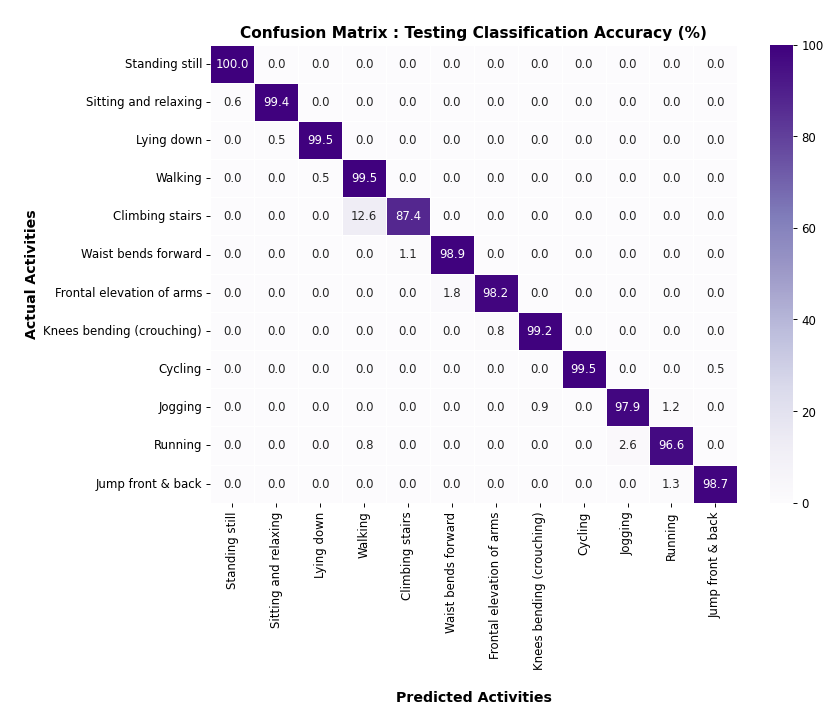

In [17]:
# Create a confusion matrix >> test set
conf_matrix = confusion_matrix(np.argmax(y_test_seq, axis=1), predctd_label)
# Classes of the the performed activity
class_labels  = ['Standing still','Sitting and relaxing','Lying down','Walking','Climbing stairs',
                 'Waist bends forward', 'Frontal elevation of arms','Knees bending (crouching)','Cycling',
                 'Jogging','Running','Jump front & back']
# Calculate accuracy percentages for each predicted class labels
class_lbl_accuracy = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
# Plot the confusion matrix with accuracy percentages
plt.figure(figsize=(10, 7), dpi=85)
sns.heatmap(class_lbl_accuracy, annot=True, fmt='.1f', cmap='Purples', xticklabels=class_labels, yticklabels=class_labels, linewidths=0.5)#plot data
plt.title('\nConfusion Matrix : Testing Classification Accuracy (%)', fontsize=13, fontweight='bold')
plt.xlabel('\nPredicted Activities', fontsize=12, fontweight='bold')
plt.ylabel('\nActual Activities', fontsize=12, fontweight='bold')
plt.show() # display plot

- Visualize acc. measurements

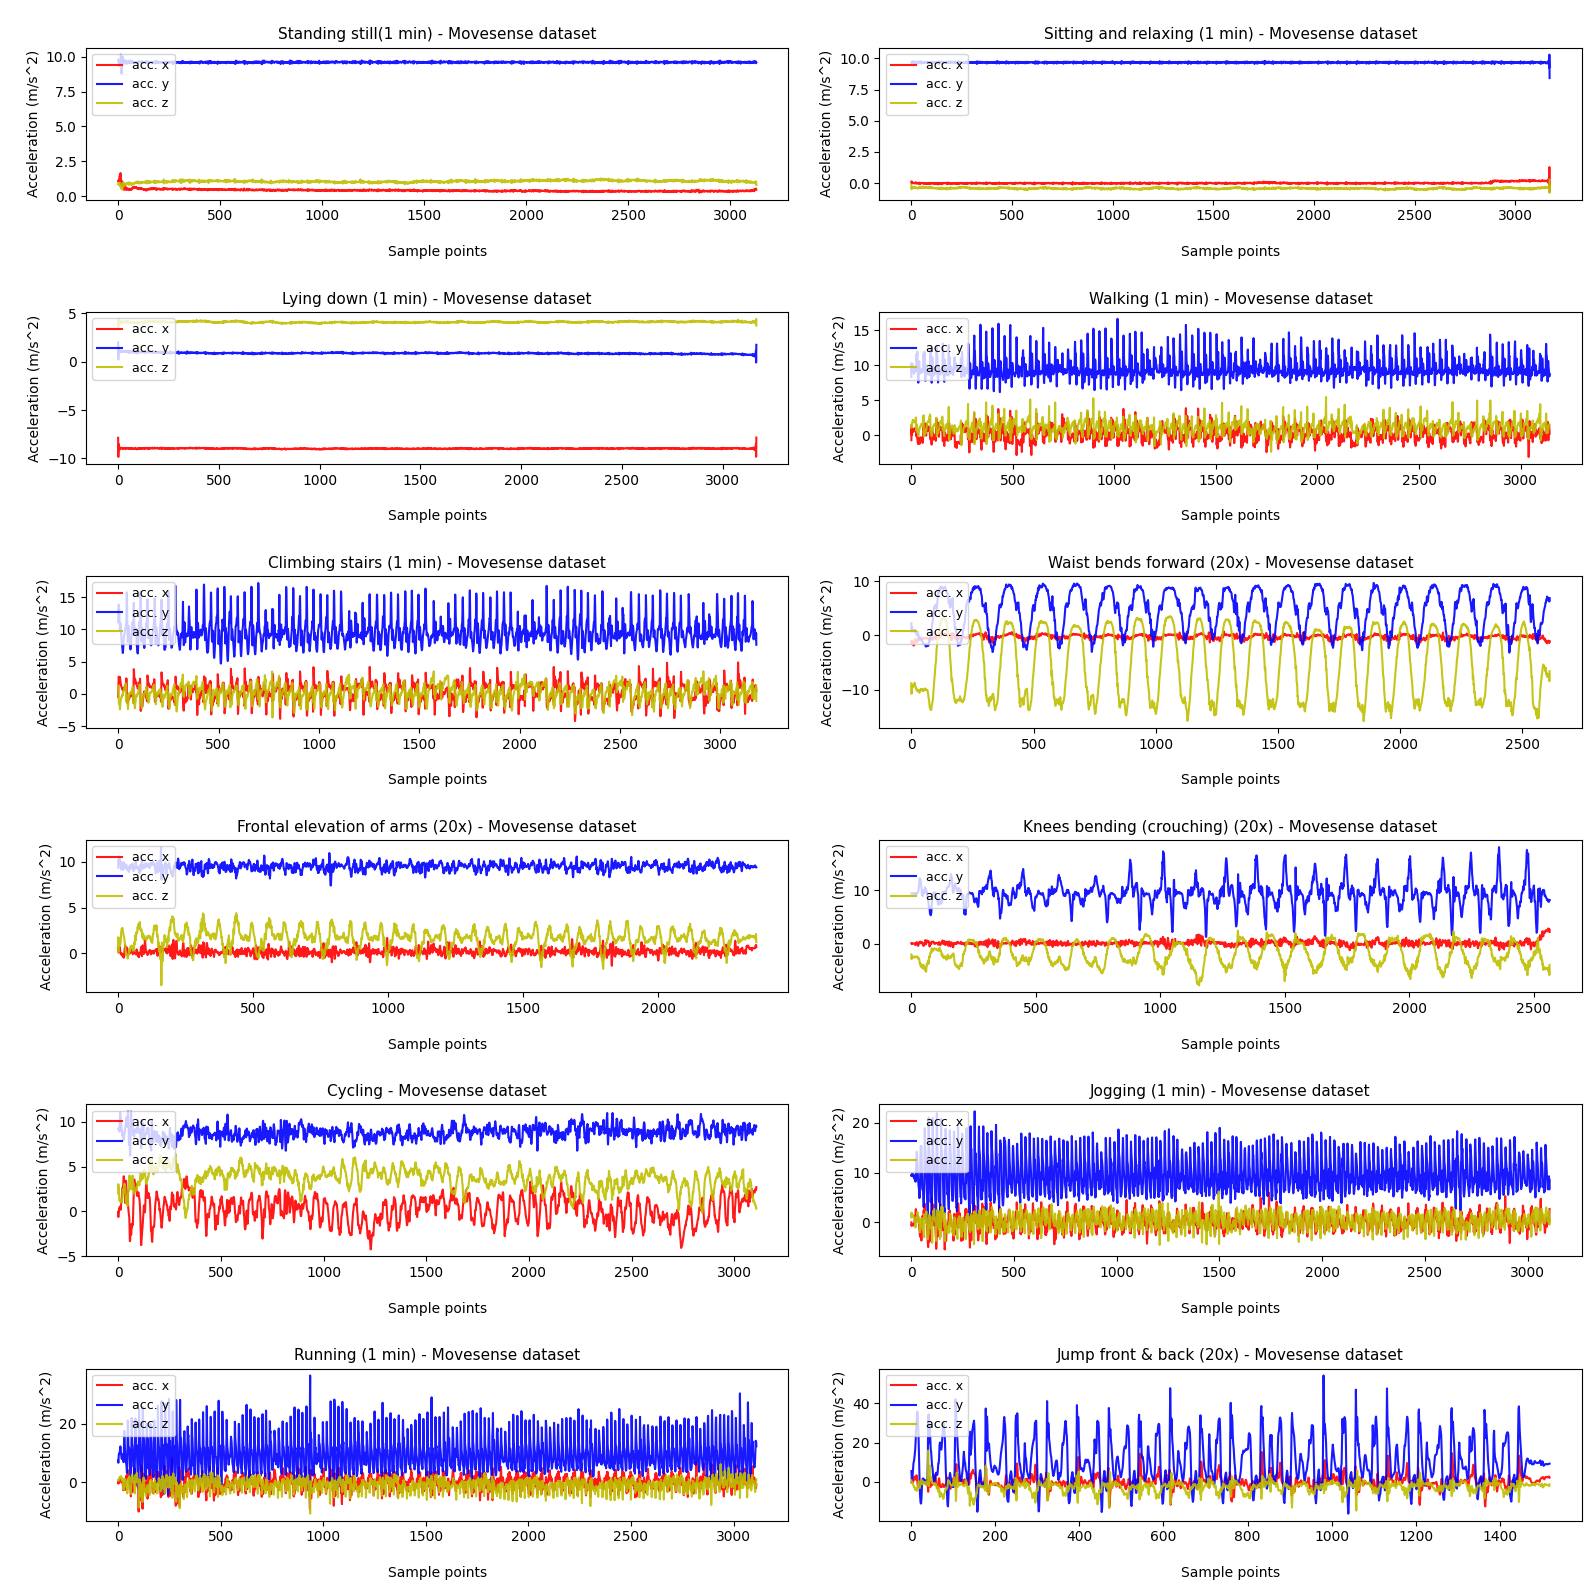

In [20]:
# Performed activities
activity_acc = {1:'Standing still(1 min)',2:'Sitting and relaxing (1 min)',3:'Lying down (1 min)',4:'Walking (1 min)',  
                    5: 'Climbing stairs (1 min)',6:'Waist bends forward (20x)',7:'Frontal elevation of arms (20x)',
                    8:'Knees bending (crouching) (20x)',9:'Cycling', 10:'Jogging (1 min)',11:'Running (1 min)',12:'Jump front & back (20x)'}
# defining axes and figure size
fig, axes = plt.subplots(6,2, figsize=(16,16),dpi=100)
# plot the acceleration measurements
for i, ax in zip(activity_acc.keys(), axes.flat):
    ax.plot(filtered_movement_data[filtered_movement_data['classes']==i].reset_index(drop=True)['x'],c='r',alpha=0.9,label='acc. x')
    ax.plot(filtered_movement_data[filtered_movement_data['classes']==i].reset_index(drop=True)['y'],c='b',alpha=0.9,label='acc. y')
    ax.plot(filtered_movement_data[filtered_movement_data['classes']==i].reset_index(drop=True)['z'],c='y',alpha=0.9,label='acc. z')
    ax.set_title(f'\n{activity_acc[i]} - Movesense dataset', fontsize=11) # title
    ax.set_xlabel('\nSample points', fontsize=10) #x_label
    ax.set_ylabel('\nAcceleration (m/s^2)', fontsize=10)  #y_label
    ax.legend(loc="upper left", fontsize=9)
# Adjust the layout  
plt.tight_layout()
plt.show() #display plots